<br>
<br>

***
***
# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Sentiment analysis of book reviews
***
***

<br>
<br>

### Abstract

An extensive investigation, involving visualisations, analytic Bayesian statistics, and neural network design applied to sentiment analysis of often poorly-structured text. 

We have downloaded a dataset of 300,000 rows from kaggle.com. Each row represents a review of a book uploaded to Goodreads.com. Included is information on the book, the average rating of the book, the rating awarded by the specific review, the name of the reviewer, and the text of the review. We investigate this first, by creating dense visualisations, showing how each reviewer's scores deviates from the rest of her peers. In doing so, we find anomalous reviewers, which may allow for detection of fraudulent reviews.

We next analyse the statistics of the reviews awarded by each reviewer, according to an analytic Bayesian analysis. By doing so, we gain two estimates for the *entropy* of an individual's reviews, which we argue is tantamount to measuring how discerning they are as a reviewer. We show that, contrary to expectations, prolific reviewers are likely to be less discerning that their peers with fewer reviews. This may be due to prolific reviewers wishing to write many reviews for its own sake, and seeking out many very good or many very bad books. This analysis may be used to seek out particularly competent book reviewers. We then investigate how reviewers of different nationalities and genders are rated. This allows us to check for unconscious bias in the reviewing world.

Finally, we examine how the score of a review may be predicted from the text of the review. We classify reviews according to three roughly equal categories: bad (less than 4-stars), good (4-stars) and excellent (5-stars). We perform cleaning of data, optimisation of network design, and design of a custom pipeline to perform 3-class classification with a binary classifier network. The result is a network that can identify the correct category over 50% of the time. In particular, bad reviews are only mis-identified as excellent reviews around 4% of the time.

<br> 

### Contents 

- 0: &emsp;  Load libraries and data
- 1: &emsp;  Cleaning data
- 2: &emsp;  Plotting the difference between an individual reviewer and the crowd
- 3: &emsp;  Are prolific reviewers more discerning?
- 4: &emsp;  Countries and genders
- 5: &emsp;  Predicting review scores
    - 5a: &emsp; Constructing the models
    - 5b: &emsp; Multi-categorical classification with a binary neural network
    - 5c: &emsp; Evaluating the model


<br>
<br>

<img src="london_library.jpg" style="height:500px">

***
***
## 0: &emsp; Load libraries and data
***
***

In [3]:
# Fundamental
import numpy as np
from numpy import array as na
import pandas as pd

# General
import pickle
import h5py
import time
import warnings

# Plotting
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Web scraping
import urllib
from bs4 import BeautifulSoup

# Machine learning
import sklearn as skl
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Deep learning
from tensorflow.python import keras as ks
from tensorflow.keras.layers import Dense, Activation, LSTM, Embedding, Dropout, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Settings
%matplotlib inline
sns.set(rc={'figure.figsize':(10,8)})
pd.options.mode.chained_assignment = None # Unecessary warning
warnings.filterwarnings('ignore') # Not generally advised, but here excludes unnecessary warnings

In [4]:
# Load data for sentiment analysis
revs = pd.read_csv('br.csv',nrows=300000)
revs = revs.rename(index=str, columns={'reviewerName':'name', 'ratingsCount':'count', 'reviewerRatings':'revrat'})

***
***
## 1: &emsp; Cleaning data
***
***

We start with a dataset of reviews downloaded from goodreads.com. We initially have 300,000 rows, but we may have to eliminate some of these. Note the structure of the dataset: each book is represented only once, but each reviewer may have multiple reviews. We are given each book's rating (i.e. their *crowd rating* - the average of all Goodreads reviews for this book, including ones not shown here), and the rating of a given review (revrat).

In [600]:
print('Number of rows =',len(revs))
print('Number of unique reviewers =',len(revs.groupby('name')['name'].count().sort_values(ascending=False).values))
revs.head(10)

Number of rows = 300000
Number of unique reviewers = 77587


,bookID,title,author,rating,count,reviewsCount,name,revrat,review
0,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.73,22,1,Charles G,3.0,NaN
1,8,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",J.K. Rowling,4.77,34107,156,✿Katherine Elizabeth✿,5.0,NaN
2,3,Harry Potter and the Sorcerer's Stone,J.K. Rowling,4.44,4911929,77741,Lora,5.0,I'm going to keep this brief since there isn't...
3,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.54,1810404,28053,Cait (Paper Fury),5.0,"""Read Harry Potter!"" they said. ""It'll be fun!..."
4,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.47,1862749,29308,Diane ϟ [ Lestrange ],5.0,NaN
5,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.38,1936698,35055,Zoë,5.0,NaN
6,7,"The Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,4.73,26702,909,Jen Holman,5.0,I do not own this spiffy box set of Harry Pott...
7,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.53,2000827,37005,Inge,5.0,NaN
8,8053,Charlie Oink (Easy Peasy People),Roger Hargreaves,4.33,3,0,Ashton,5.0,NaN
9,6,Harry Potter and the Goblet of Fire (Harry Pot...,J.K. Rowling,4.53,1897821,31817,Zoë,5.0,NaN


First we want to filter out duplicate reviews, which exist as shown here, and we want to filter out rows that have no review or no rating.

In [597]:
revs[(revs.title=='Ivanhoe') & (revs.name.str.contains('Bill'))]

,bookID,title,author,rating,count,reviewsCount,name,revrat,review
166,6445,Ivanhoe,Walter Scott,3.75,72149,1837,Bill Kerwin,4.0,NaN
167,6444,Ivanhoe,Walter Scott,3.75,72153,1837,Bill Kerwin,4.0,NaN
825,6440,Ivanhoe,Walter Scott,3.75,72147,1837,Bill Kerwin,4.0,NaN
826,6443,Ivanhoe,Walter Scott,3.75,72147,1837,Bill Kerwin,4.0,NaN
39340,40500,Ivanhoe,Walter Scott,3.75,72169,1838,Bill Kerwin,4.0,NaN
87614,93114,Ivanhoe,Walter Scott,3.75,72172,1838,Bill Kerwin,4.0,NaN


In [5]:
def cleanDF(dfIn):
    df = dfIn.copy()
    df['title'] = df['title'].apply(lambda x: x.strip(' '))
    df = df.drop_duplicates(subset=['title','name'])
    df = df.drop_duplicates(subset=['review'])
    df = revs[(~revs['review'].isnull())  &  (~revs['revrat'].isnull())].sample(frac=1).reset_index()
    df = df.drop(columns=['index'])
    return df
revs = cleanDF(revs)

***
***
## 2: &emsp; Plotting the difference between an individual reviewer and the crowd
***
***

An interesting first question that we might ask is: "How does each reviewer compare to the rest of Goodread's reviewers?" We look at the average revrat of the books that a reviewer has rated, and compare it to the book's rating. This is shown in the figure below.

In [603]:
# We sort for prominent reviewers, looking for the top NTopRevs by number of reviews.

NTopRevs = 2000

prominentRevs = revs.groupby('name')['revrat'].count().sort_values(ascending=False).index[:NTopRevs]
revsOfProm = revs[revs.name.isin(prominentRevs)]
revsOfProm = revsOfProm[~revsOfProm.name.isin(['BookDB'])] # This seems to be an "anonymous" type review handle.

# We turn this into a multi-column-layered frame, which we can index by chained column names.
revsOfProm = revsOfProm.groupby('name')['rating','revrat'].agg([np.mean,list])
#revsOfProm.head()

In [604]:
# It is easier to deal with a flat dataframe, so we'll do that here.
revsOfProm = pd.DataFrame(revsOfProm.to_records())
revsOfProm.columns = ['name','croRatMean','croRatList','revRatMean','revRatList']

In [605]:
# Here we find the number of reviews they have made.
revsOfProm['number'] = revsOfProm['croRatList'].apply(len).values
revsOfProm['lognum'] = np.log(revsOfProm['number'])

# ...and their average deviation from the norm. Note, here variance means absolute distance (L1 norm), not the usual meaning of squared L2 norm.
revsOfProm['variance'] = revsOfProm['revRatMean']-revsOfProm['croRatMean']
revsOfProm = revsOfProm.sort_values('variance',ascending=False).reset_index().drop(columns='index')

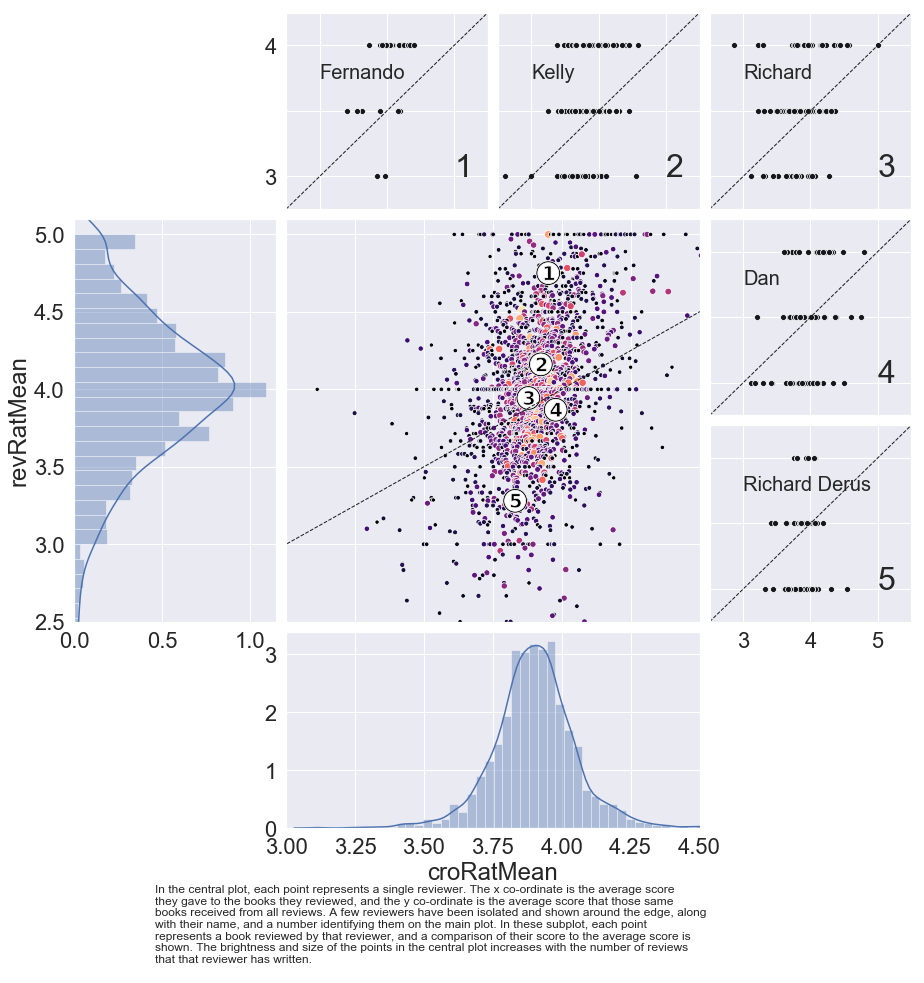

In [606]:
# This indicates the distribution of points to choose for the isolated graphs. We choose a highly variable subset from the subset of many review numbers. 
isolatingLinspace = np.linspace(0.015,.999,5)
superHighRevSubset = revsOfProm[revsOfProm['number']>100].sort_values('variance',ascending=False).reset_index()
isolators = superHighRevSubset.iloc[(isolatingLinspace*len(superHighRevSubset)).astype(int)]['index'].values

numScale = .8 # This scales the numbers in the main graph

fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(4, 4, wspace=0.05, hspace=0.05)
main_ax = fig.add_subplot(grid[1:3, 1:3])
ax0 = fig.add_subplot(grid[0, 1])
ax1 = fig.add_subplot(grid[0, 2])
ax2 = fig.add_subplot(grid[0, 3])
ax3 = fig.add_subplot(grid[1, 3])
ax4 = fig.add_subplot(grid[2, 3])
ax_hx = fig.add_subplot(grid[3, 1:3])
ax_hy = fig.add_subplot(grid[1:3, 0])

contspace = np.linspace(2.5,5.5)

sns.scatterplot(
    x='croRatMean',
    y='revRatMean',
    data = revsOfProm.loc[~(revsOfProm.index.isin(isolators))],
    ax=main_ax,
    hue='lognum',
    size='lognum',
    palette = cm.magma,
    legend=None
)

mainxlims = (3.0,4.5)
mainylims = (2.5,5.1)
main_ax.set_xlim(mainxlims)
main_ax.set_ylim(mainylims)
ax_hx.set_xlim(mainxlims)
ax_hy.set_ylim(mainylims)

main_ax.xaxis.set_ticklabels([]) # We use this instead of ax.set_xticks([]) to keep gridlines
main_ax.set_xlabel('')
main_ax.yaxis.set_ticklabels([])
main_ax.set_ylabel('')

ax_hx.set_xlabel('Reviewer ratings')
ax_hy.set_ylabel('Overall ratings')

main_ax.plot(contspace,contspace,'k--',linewidth=1)

for i,val in enumerate(isolators):
    ax = eval('ax{}'.format(i))
    if i!=4:
        ax.xaxis.set_ticklabels([]) 
    if i!=0:
        ax.yaxis.set_ticklabels([])
    else:
        ax.yaxis.set_ticklabels(['',3,'',4,'',5,''])
    thisRow = revsOfProm.iloc[val]
        
    sns.scatterplot([thisRow['croRatMean']],[thisRow['revRatMean']],marker='o'.format(i+1),s=[numScale*750]*5,ax=main_ax,color='black')
    sns.scatterplot([thisRow['croRatMean']],[thisRow['revRatMean']],marker='o'.format(i+1),s=[numScale*550]*5,ax=main_ax,color='white')
    sns.scatterplot([thisRow['croRatMean']],[thisRow['revRatMean']],marker='$\mathbf{{{}}}$'.format(i+1),s=[numScale*250]*5,ax=main_ax,color='black')
    
    sns.scatterplot(x=thisRow['croRatList'], y=thisRow['revRatList'], ax=ax, color=cm.bone(.1))
    
    ax.set_xlim((2.5,5.5))
    ax.set_ylim((2.5,5.5))
    ax.plot(contspace,contspace,'k--',linewidth=1)
    ax.text(x=5,y=3,s=i+1,fontsize=32);
    ax.text(x=3,y=4.5,s=thisRow['name'],fontsize=20);
    
sns.distplot(revsOfProm['croRatMean'], ax=ax_hx)
sns.distplot(revsOfProm['revRatMean'], ax=ax_hy, vertical=True)

caption = '''
In the central plot, each point represents a single reviewer. The x co-ordinate is the average score
they gave to the books they reviewed, and the y co-ordinate is the average score that those same
books received from all reviews. A few reviewers have been isolated and shown around the edge, along
with their name, and a number identifying them on the main plot. In these subplot, each point 
represents a book reviewed by that reviewer, and a comparison of their score to the average score is 
shown. The brightness and size of the points in the central plot increases with the number of reviews 
that that reviewer has written.
'''

plt.figtext(0.2, -0.01, caption, wrap=True, horizontalalignment='left', fontsize=12);


### A one-track reviewer

Many reviewers seem to have an average rating of 5 stars; implying that *all* of their reviews are 5 stars. One such reviewer is a Mr. Glenn Russel, who has, quite astonishingly, reviewed a total of 410 books, with every single one being rated 5 stars! One might be tempted to think that this is an automatic voting bot, except that his reviews run to an average of 842 words, with one review running to over 3000 words! The distribution of review lengths is shown below.

Glenn has 410 reviews
Glenn's average review length = 839 words


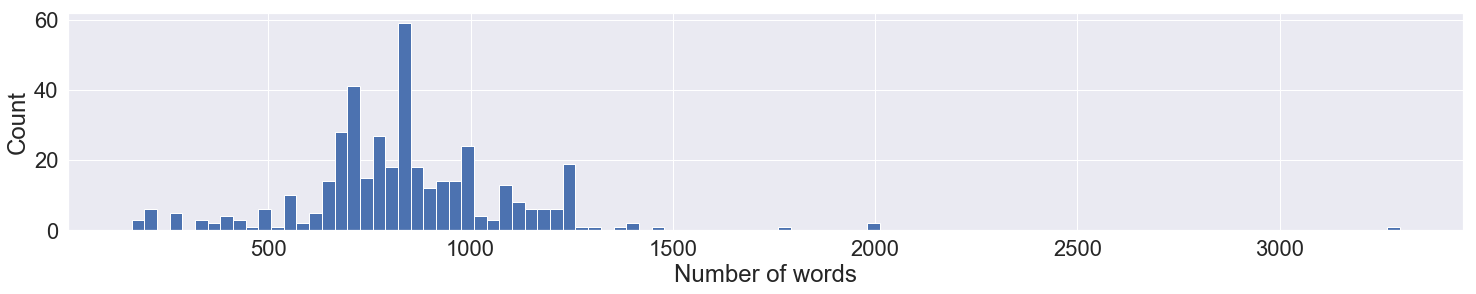

In [607]:
GlennTemp = revs[revs['name']=='Glenn Russell']
GlennTemp['revlen'] = GlennTemp['review'].str.split(" ").apply(len).values

plt.figure(figsize=(25,4))
GlennTemp['revlen'].hist(bins=100)
plt.xlabel('Number of words')
plt.ylabel('Count')
print('Glenn has {} reviews'.format(len(GlennTemp)))
print("Glenn's average review length = {} words".format(int(GlennTemp.sort_values('revlen')['revlen'].mean())))

### Discussion

As we can see, the average scores of the prominent reviewers have a larger spread than the distribution of average book scores (`croRatMean`). This is to be expected, since the `croRatMean` is calculated from an average over many more reviews than the `revRatMean` values (since they are the average of *all* reviews for each book, not just the ones given in our table). In the next subsection, we ask whether the distributions that we see are to be expected simply by statistical effects, or whether we can learn something about different classes of reviewers.
<br><br>
    We may also note that most very highly prolific reviewers (i.e. large, bright spots) are near the centre. This is to be expected, since as someone writes more reviews, they are more likely to regress to the mean. In other words, it might be common for someone to write a single 1-star review, but it would be very unusual for them to write a hundred.

***
***
## 3: &emsp; Are prolific reviewers more discerning?
***
***

### Variance

We noted above that the average ratings of prolific reviewers are significantly more spread out than those of the "crowd." There are two possible reasons for this. It could be that the spread of `revRatMean` is greater than that of `croRatMean` simply because it consists of means drawn from a smaller sample. Alternatively, it could be the case that 
If these values (`croRatMean` and `revRatMean`) were both normally distributed, and each reviewer had rated the same number of books, $N_R$. In that case, by the additivity of variances of normally-distributed random variables, we could expect

$$
\textrm{Var}(\text{revRatMean}) = \textrm{Var}(\text{croRatMean}) + \frac{\textrm{Var}(X_{R,B})}{N_R},
$$

where the quantity

$$X_{R,B} = S_{R,B} - \left\langle S_{R,B}\right\rangle_R
$$ 

is the "excess" score given to book $B$ by reviewer $R$, and $S_{R,B}$ is the corresponding actual score.
<br><br>
However, these assumptions do not seem to be justified. Whist `croRatMean` is approximately normal due to the central limit theorem, the same cannot be said for `croRatMean`, mainly due to the small number of reviews that many reviewers have written, combined with the discrete and compact nature of the set of possible review scores. Additionally, problems are posed by the fact that there is a large range in the number of reviews that have been written by each reviewer.
<br><br>

### Entropy

Instead, we choose a different metric for measuring how discerning a reviewer: the **entropy**. This is a property of a discrete probability distribution, that measures the information contained within it. It also measures the *flatness* of the distribution. Here, the probability distribution in question is the proportion of times that a reviewer rates awards each number of stars. So a reviewer that awards 1, 2, 3, 4, and 5 stars 20% of the time (a *flat* distribution) each we would say is highly discerning - they obviously have a rather nuanced opinion of what defines the boundary between a good book and a slightly better book.

On the other hand, a reviewer who rates all books as 5-stars (a *delta* distribution) is not very discerning. Nor is someone who rates 50% of their books as 1-star and 50% as 5-stars (*bimodal* distribution). This shows how entropy is a better measure than variance: the flat distibution has a higher entropy than the bimodal, but a lower variance.

Concretely, we identify for each reviewer, the set of numbers $N_1, N_2, N_3, N_4, N_5$, which are the number of times that they have awarded a 1, 2, 3, 4, and 5-star review respectively. We then find $p_i = N_i/N$ for $i=1,\cdots,5$, where $N=\sum_{i=1}^5 N_i$. A reviewer's entropy may then be calculated as 

$$
S_\text{simple}\left(\left\{ p_i \right\}_i\right) = -\sum_{i=1}^5 p_i \log(p_i).
$$

However, we run into a problem here. Note that some reviewers have only a small number of reviews. Consider a reviewer who is highly discerning, and would, given the chance to rate a thousand books, award reviews resulting in a flat distribution, and so a high entropy. However, suppose she has only written one review, say, 3-stars. If we simply calculate $p_i$ as $N_i/N$, then it will appear that she has a delta distribution, and so a very low entropy (in fact, $S=0$). Instead, we must have a way of accounting for the fact that a low review count does not necessarily imply a low entropy of this person's "true" distribution of review scores (if such a concept is even meaningful).

### Bayesian analysis

To do this, we use the concept of Bayesian analysis. We assume initially, that each reviewer awards scores according to the average distribution of her peers. We then update our estimate of these scores according to the evidence of the actual scores they award.

To be precise in our notation, we shall let $\tilde{p}_i$ be a hypothesised value for a reviewer's *true* likelihood of awarding $i$ stars (again, putting aside philisophical objections as to whether such a quantity has any kind of ontological basis). We now want to estimate

$$
L\left(\tilde{p}_1, \tilde{p}_2, \cdots, \tilde{p}_5 | N_1, N_2, \cdots, N_5\right).
$$

Here, $L(H|X)$ is the likelihood of hypothesis $H$ given measured data $X$. According to Bayes' theorem, this may be calculated according to:

$$
L\left(\left\{\tilde{p}_i \right\} | \left\{N_i \right\}\right) \propto L\left(\left\{N_i \right\} | \left\{\tilde{p}_i \right\}\right) \times L\left(\left\{\tilde{p}_i \right\} \right).
$$

The quantity $L\left(\left\{\tilde{p}_i \right\} \right)$ is known as the *prior* distribution of $\left\{\tilde{p}_i \right\}$. It represents our best guesses for our expectations of the values of $\left\{\tilde{p}_i \right\}$ in the absence of new evidence. We shall set these to be Gaussians, with means of $\mu_i$ and standard deviations of $\sigma_i$, which will be calculated by finding the average proportion of time that $i$-stars is awarded, and the corresponding uncertainty. Note that this is not the same as the Gaussian assumption that we rejected earlier. For one thing, they are calculated from all reviews, so we have enough data to apply the central limit theorem. It is also taken on a space of probability (continuous), not on the space of number of stars (discrete).

Given a prior probability set of $\left\{\tilde{p}_i \right\}$, the likelihood of measuring $\left\{N_i \right\}$ is given by:

$$
L\left(\left\{N_i \right\} | \left\{\tilde{p}_i \right\}\right) \propto \prod_{i=1}^5 p_i^{N_i}.
$$

This means we can evaluate Bayes' theorem as 

$$
L\left(\left\{\tilde{p}_i \right\} | \left\{N_i \right\}\right) \propto \prod_{i=1}^5 p_i^{N_i} \frac{1}{(2\pi)^{5/2} \sigma_i} \exp \left(\frac{\left(\tilde{p}_i - \mu_i\right)^2}{2\sigma^2}\right).
$$

To this *posterior* distribution we apply the *maximum likelihood estimator*. That is, we say that the most likely value for $\tilde{p}_i$ is of course the one which maximises the posterior distribution. Given that the distribution is continuous, this equates to finding $\tilde{p}_i$ such that

$$
\frac{\text{d}}{\text{d}\tilde{p}_i} L\left(\left\{\tilde{p}_i \right\} | \left\{N_i \right\}\right) = 0.
$$

Differentiating our expression for the posteriors, we find that this is the case when

$$
\tilde{p}_i^{N_i} \frac{\mu_i - \tilde{p}_i}{\sigma_i^2} + N_i \tilde{p}_i^{N_i-1} = 0 \\
\longrightarrow \tilde{p}_i^2 - \mu_i \tilde{p}_i - \sigma_i^2 N_i = 0
$$

Let $\bar{\tilde{p}}_i$ be the best value for $\tilde{p}_i$ according to the maximum likelihood estimator. By solving the above equation, and normalising the results so that they sum to $1$, we get 

$$
\bar{\tilde{p}}_i = \mathcal{P}_i/\mathcal{P},
$$

where $\mathcal{P} = \sum_{i=1}^5 \mathcal{P}_i$, and

$$
\mathcal{P}_i = \frac{\mu_i}{2}\left( 1+ \sqrt{1+N_i\left[ 2\frac{\sigma_i}{\mu_i} \right]^2}  \right).
$$

We then examine the Bayesian entropy of a given reviewer as 

$$
S_\text{Bayes}\left(\text{reviewer}\right) = S\left( \left\{\bar{\tilde{p}}_i\right\}_i \right)
$$

In [6]:
counterFrames = []
for i in [1,3,4,5]:
    df = revs[revs['revrat']==i].groupby('name')['bookID'].count().reset_index()
    df.columns = ['name', 'count_{}'.format(i)]
    counterFrames.append(df)
distribs = counterFrames[0]
for i in [1,2,3]:
    distribs = distribs.merge(counterFrames[i],left_on='name',right_on='name')
distribs = distribs.sample(frac=1).reset_index(drop=True)
distribs['totals'] = distribs.sum(axis=1)

# These are the actual fractions of the number rated
simplabels = ['p1','p3','p4','p5']
for label in simplabels:
    distribs[label] = distribs['count_{}'.format(label[1])]/distribs['totals']

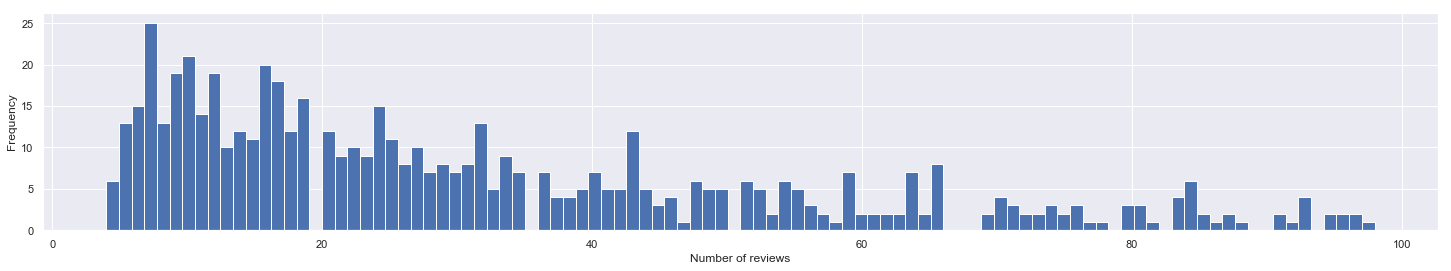

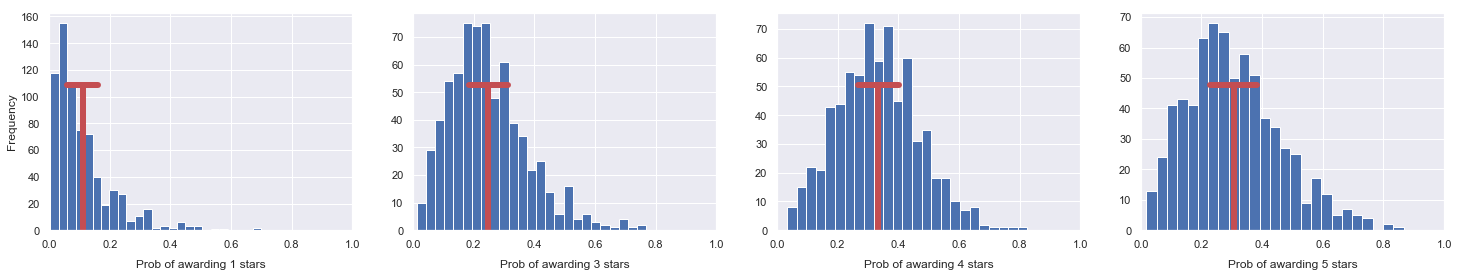

In [7]:
fig = plt.figure(figsize=(25,4))
distribs[distribs['totals']<100]['totals'].hist(bins=100)
plt.xlabel('Number of reviews')
plt.ylabel('Frequency')
plt.show()
fig, (ax1,ax3,ax4,ax5) = plt.subplots(ncols=4,figsize=(25,4))
for i,val in enumerate([1,3,4,5]):
    ax = eval('ax{}'.format(val))
    series = distribs['count_{}'.format(val)]/distribs['totals']
    series.hist(bins=25,ax=ax);
    mean = series.mean()
    sd = series.std()
    mid = ax.get_ylim()[1]*0.67
    ax.plot([mean]*20,np.linspace(0,mid,20),'r',linewidth=6)
    ax.plot(np.linspace(mean-sd/2,mean+sd/2,20),[mid]*20,'r',linewidth=6)
    ax.set_xlim((0,1))
    ax.set_xlabel('Prob of awarding {} stars'.format(val),labelpad=10)
ax1.set_ylabel('Frequency')

In [10]:
seriesSet = [distribs['count_{}'.format(val)]/distribs['totals'] for val in [1,3,4,5]]
muSet = [series.mean() for series in seriesSet]
sdSet = [series.std() for series in seriesSet]

# These are the Bayesian corrected fractions of the number rated
baylabels = ['P1','P3','P4','P5']
for ind,label in enumerate(baylabels):
    distribs[label] = muSet[ind] * (1+np.sqrt(  1 + distribs['count_{}'.format(label[1])]*(2*sdSet[ind]/muSet[ind])**2  ))
distribs['normalise'] = distribs['P1']+distribs['P3']+distribs['P4']+distribs['P5']

for label in bayslabels:
    distribs[label] = distribs[label]/distribs['normalise']
distribs.drop(columns=['normalise'],inplace=True)

In [11]:
def entropy(pset):
    ent = 0
    for p in pset:
        ent += -p*np.log(p)/np.log(4)
        # This normalises so a flat distribution has S=1
    return ent

In [12]:
distribs['entropy_simpl']=0
distribs['entropy_bayes'] =0
for i in range(len(distribs)):
    distribs.loc[i,'entropy_simpl'] = entropy([distribs.loc[i,label] for label in simplabels])
    distribs.loc[i,'entropy_bayes'] = entropy([distribs.loc[i,label] for label in bayslabels])

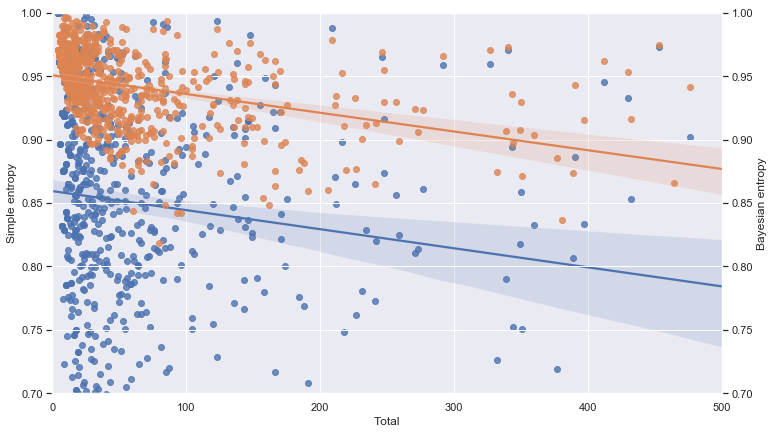

In [19]:
maxTotal = 500
restricted = distribs[distribs['totals']<maxTotal]
fig,ax1 = plt.subplots(figsize=(12,7))
ax2 = ax1.twinx()
ax1.set_xlim((0,maxTotal))
ax2.set_xlim((0,maxTotal))
ax1.set_ylim((0.7,1))
ax2.set_ylim((0.7,1))
sns.regplot(x='totals',y='entropy_simpl',data=restricted,ax=ax1)
sns.regplot(x='totals',y='entropy_bayes',data=restricted,ax=ax2)
ax1.set_xlabel('Total')
ax1.set_ylabel('Simple entropy')
ax2.set_ylabel('Bayesian entropy')

### Discussion

Interestingly, we see that both simple and Bayesian entropy decrease with review number. If we look at the reviews with the minimum and maximum entropy (below), we see that high entropy is only achieved by a few people who have awarded one review each of 1, 3, 4, and 5 stars (we omit 2 stars since none are present in the dataset).

In [26]:
distribs.sort_values('entropy_simpl',ascending=False).head()

,name,count_1,count_3,count_4,count_5,totals,p1,p3,p4,p5,P1,P3,P4,P5,entropy_simpl,entropy_bayes
296,Pablo,1,1,1,1,4,0.25,0.25,0.25,0.25,0.139709,0.247591,0.310705,0.301995,1.0,0.97049
519,Bird,1,1,1,1,4,0.25,0.25,0.25,0.25,0.139709,0.247591,0.310705,0.301995,1.0,0.97049
358,Margie,2,2,2,2,8,0.25,0.25,0.25,0.25,0.150172,0.247874,0.300927,0.301027,1.0,0.97616
436,Grant,1,1,1,1,4,0.25,0.25,0.25,0.25,0.139709,0.247591,0.310705,0.301995,1.0,0.97049
323,Erwin,1,1,1,1,4,0.25,0.25,0.25,0.25,0.139709,0.247591,0.310705,0.301995,1.0,0.97049


In [27]:
distribs.sort_values('entropy_simpl',ascending=False).tail()

,name,count_1,count_3,count_4,count_5,totals,p1,p3,p4,p5,P1,P3,P4,P5,entropy_simpl,entropy_bayes
54,Sarah Crawford,2,2,46,9,59,0.033898,0.033898,0.779661,0.152542,0.091374,0.150821,0.477613,0.280192,0.512396,0.875253
68,Betsy,4,4,7,69,84,0.047619,0.047619,0.083333,0.821429,0.098945,0.153327,0.208324,0.539403,0.475089,0.848416
626,Laura Verret,1,2,19,1,23,0.043478,0.086957,0.826087,0.043478,0.102940,0.207771,0.466774,0.222515,0.463724,0.902078
183,Emily May,2,1,12,65,80,0.025000,0.012500,0.150000,0.812500,0.080961,0.117334,0.255853,0.545852,0.433005,0.818126
129,Lora,4,2,2,52,60,0.066667,0.033333,0.033333,0.866667,0.114995,0.149492,0.181488,0.554025,0.383255,0.843781


***
***
## 4: &emsp; Countries and genders
***
***

Here, we want to see how authors of different gender and nationality stack up. Unfortunately, the dataset does not include this information, so we will have to scrape Wikipedia for it. We do this by searching for the first occurance of a nationality, and the first instance of "he, his, him" or "she, hers, her" in the text.

In [22]:
with open('countries.txt','r') as file:
    countries = file.read().split('\n')
try:
    countries.pop(countries.index(''))
except ValueError:
    pass

def posmin(*args):
    args = list(args)
    for i in range(len(args)):
        if args[i] == -1:
            args[i] = 10e8
    return min(args)

def getGenderCountry(name):
    name = name.replace(' ','_')
    name = name.replace('.','._')
    name = name.replace('__','_')
    name = name.replace('__','_')
    url = 'https://en.wikipedia.org/wiki/{}'.format(name)
    try:
        uh = urllib.request.urlopen(url)
        html = uh.read().decode()
        soup = BeautifulSoup(html, 'html.parser')
    except:
        return '-','-'
    bodies = soup.body.find_all('p')
    
    gender  = '-'
    country = '-'
    
    foundGender  = 0
    foundCountry = 0
    
    for body in bodies:
        if foundGender==0:
            body = str(body).lower()
            m_index = posmin(body.find(' he '),body.find(' his '),body.find(' him '))
            m_index = posmin(m_index, body.find(' he.'),body.find(' his.'),body.find(' him.'))
            m_index = posmin(m_index, body.find(' he,'),body.find(' his,'),body.find(' him,'))
            f_index = posmin(body.find(' she '),body.find(' hers '),body.find(' her '))
            f_index = posmin(f_index, body.find(' she.'),body.find(' hers.'),body.find(' her.'))
            f_index = posmin(f_index, body.find(' she,'),body.find(' hers,'),body.find(' her,'))
            if   posmin(m_index,f_index) == 10e8: continue
            elif posmin(m_index,f_index) == m_index: 
                gender = 'M'
                foundGender = 1
            elif posmin(m_index,f_index) == f_index: 
                gender = 'F'
                foundGender = 1
        
        if foundCountry==0:
            for cty in countries:
                ctyindex = posmin(body.find(cty))
                if ctyindex == 10e8: 
                    continue
                else:
                    country = cty
                    if country=='english':
                        country='british'
                    foundCountry = 1
                    break
        
        if foundGender==1 and foundCountry==1:
            break
    
    return gender, country

In [93]:
try:
    revs = pd.read_pickle('gettingGC_02.p')
    checkFrom = revs[revs['gender']=='--'].index[0] # The first unchecked
    print('Loaded')
except:
    checkFrom = 0
    revs['gender']='--'
    revs['nationality']='--'
    print('Reset')

Reset


In [ ]:
for i in range(checkFrom,len(revs)):
    if i%10==0:
        print(i)
    if revs.loc[i,'gender']!='--': continue
    author = revs.loc[i,'author']
    gender,country = getGenderCountry(author)
    revs.loc[i,'gender']=gender
    revs.loc[i,'nationality']=country
    revs.to_pickle('gettingGC_02.p')

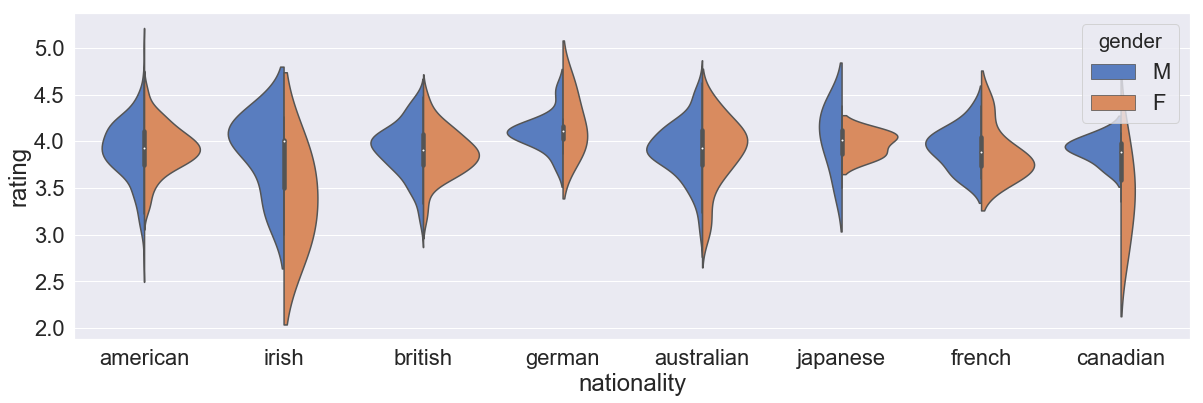

In [302]:
revsViolinPlot = revs[~(revs['gender'].str.contains('-')) & ~(revs['nationality'].str.contains('-'))]
topNations = revsViolinPlot.groupby('nationality')['bookID'].agg(len).reset_index(drop=0)
topNations.columns = ['nationality','count']
topNations = topNations.sort_values('count',ascending=False).reset_index(drop=1)

# Use one of the below lines, to pick countries over a certain representation, or top few represented countries.
#topNationsList = topNations[topNations['count']>5]['nationality'].values
topNationsList = topNations[:8]['nationality'].values

revsViolinPlot = revsViolinPlot[revsViolinPlot['nationality'].str.contains('|'.join(list(topNationsList)))]

sns.set(font_scale=2)
plt.figure(figsize=(20,6))
sns.violinplot(x="nationality", y="rating", 
               hue="gender", data=revsViolinPlot, palette="muted", split=True)

***
***
## 5: &emsp; Predicting review scores
***
***

Here we will try to predict what rating someone will assign to a book from the text of their review. We will first try applying a Long-Short Term Memory (LSTM) neural network to the text corpus. Unlike a standard neural network, or multi-layer preceptron (MLP), this takes in a *sequence* of data points, and looks for patterns across the sequence.
<br><br>
This is highly relevant for sentiment classification of a body of text. To see why this is the case, suppose we instead just looked at each word, and classified it according to representing a *positive* or *negative* review. According to this, we might classify a word such as "great" as *positive*. However, a review which calls a book a "great disappointment" is clearly a *negative* review. We might similarly struggle to accurately classify such excerpts as "terribly powerful," "dazzlingly rubbish," or "not bad." The LSTM accounts for such structures by considering each word, and well as the words preceding it, when making a classification.
<br><br>
As we see from the below (leftmost) graph, most people rated their books as 4 or 5 stars, with no-one giving a rating of 2 stars! As such we will combine the ratings of 1 and 3 stars. We will try to classify whether someone rated a book as "bad" (≤ 3 stars), "average" (4 stars), or "good" (5 stars). We will encode this in the feature "ratcat" (for "rating category"), which will be 0, 1, or 2, respectively, shown in the rightmost graph.

In [627]:
revs['ratcat']=0
revs.loc[revs['revrat']==4,'ratcat'] = 1
revs.loc[revs['revrat']==5,'ratcat'] = 2

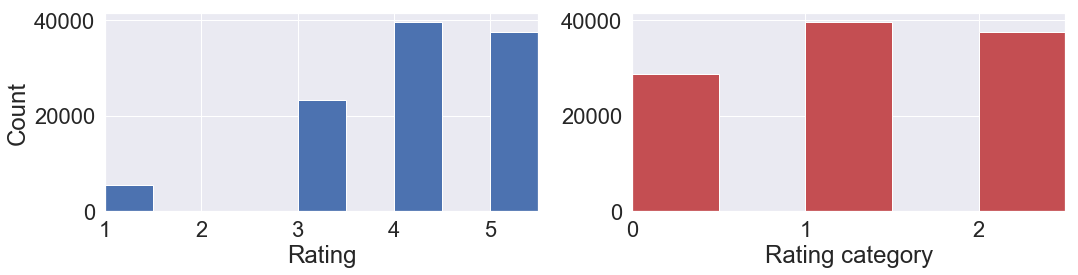

In [634]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,4))
fig.tight_layout()
revratVals = revs['revrat'].values
ratcatVals = revs['ratcat'].values
ax1.hist(revratVals,bins=np.arange(0.5,6,0.5),color='b')
ax2.hist(ratcatVals,bins=np.arange(-0.5,3,0.5),color='r')
ax1.set_xlabel('Rating')
ax1.set_xticks([1,2,3,4,5]);
ax1.set_ylabel('Count')
ax1.set_xlim([1,5.5]);
ax2.set_xlabel('Rating category')
ax2.set_xticks([0,1,2]);
#ax2.set_yticks([]);
ax2.set_xlim([0,2.5]);

Here, we can modify our training set so that we have an equal number of each class. This can increase our sensetivity to features that represent a less-common class, while possibly reducing our final cross-validated accuracy, by making the network think that one class is more common than it actually is. We try it with both equalize=0 and =1.

***
## 5a: &emsp; Constructing the models
***

First, we want to modify the reviews so that they are most suitable to pass through an LSTM. This means cutting them at a certain size, and replacing and removing certain words and characters. First we remove most non-alphanumeric characters. We standardise numbers, as being either small (and set equal to 1) or large (and set equal to 2). This is to minimise the number of words in our vocabulary, to minimise the space over which our embedding operates. We also set exclamation and question marks to be their own words.

In [7]:
max_len = 350 # Max review length in words

def wordify(word,stem=1):
    '''
    This takes an input word and removes punctuation, capitals, etc, and tries to minimise number of words.
    '''
    out = word
    for char in ''' :;'"+@#[]{}/\|$%^&*_<>•¡™£€∞§¶•ª ''':
        out = out.replace(char,'')
    for char in ',.()':
        out = out.replace(char,' ')
    out.replace('?',' ?')
    out.replace('!',' !')
    out.replace('-',' ')
    try:
        outnum = int(out)
        if outnum<10:
            outnum=1
        else:
            outnum=2
        out = str(outnum)
    except ValueError:
        pass
    out = out.lower()
    if stem: 
        out = stemmer.stem(out)
    return out

def getShortRevs(dfIn,max_len,verbose=False):
    '''Gets shortened-to-length-n versions of the reviews for passing to w2v.    
    To do here: Drop short words?
    '''
    df = dfIn.copy()
    revs['revShort'] = ''
    for irow in range(len(df)):
        if verbose and irow%1000==0:
            print('Row {} of {}.'.format(irow,len(df)))
        thisShortRev = ''
        for word in df.loc[irow,'review'].split(' ')[:max_len]:
            thisShortRev += wordify(word)
            thisShortRev += ' '
        thisShortRev.strip(' ')
        thisShortRev = thisShortRev[:-1] # Drops the blank string at the end.
        df.loc[irow,'revShort'] = thisShortRev
    if verbose:
        print('getShortRevs - Done')
    return df

### Saving and loading short reviews

In [649]:
#revs = getShortRevs(revs[:10],max_len,1)
revs.to_pickle('revs_savepoint.p')

In [4]:
revs = pd.read_pickle('revs_savepoint.p')

We first turn our dataframe into the relevant numerical test and train arrays.

In [5]:
trfrac = 0.7
max_words = 1000  # Max number of words to tokenize

equalize=0

def getTRCV(maxNum=20000,trfrac=0.7):
    df   = revs[:maxNum] # We'll only looking at 20,000 at a time while we create/tune the model.
    dftr = df.sample(frac=trfrac)
    dfcv = df.sample(frac=1-trfrac)

    if equalize==1:
        df1 = dftr[dftr['revrat']<4]
        df4 = dftr[dftr['revrat']==4]
        df5 = dftr[dftr['revrat']==5]
        minlen = min(len(df1),len(df4),len(df5))
        df1 = df1[:minlen]
        df4 = df4[:minlen]
        df5 = df5[:minlen]
        dftr = pd.concat([df1,df4,df5]).reset_index(drop=1)
    dftr= dftr.sample(frac=1)

    enc = LabelBinarizer()
    enc.fit([0,1,2])

    # Train values
    Xtr = dftr['revShort'].values
    rats = dftr['revrat'].values
    ytr = np.ones(len(rats))
    ytr[np.where(rats<4)[0]]=0
    ytr[np.where(rats>4)[0]]=2
    ytr = enc.transform(ytr)

    # Train values
    Xcv = dfcv['revShort'].values
    rats = dfcv['revrat'].values
    ycv = np.ones(len(rats))
    ycv[np.where(rats<4)[0]]=0
    ycv[np.where(rats>4)[0]]=2
    
    return Xtr,ytr,Xcv,ycv

Xtr,ytr,Xcv,ycv = getTRCV(20000,0.7)

In [8]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(Xtr)

seq_tr = tok.texts_to_sequences(Xtr)
seqMat_tr = sequence.pad_sequences(seq_tr,maxlen=max_len)

seq_cv = tok.texts_to_sequences(Xcv)
seqMat_cv = sequence.pad_sequences(seq_cv,maxlen=max_len)

Now we create our model - an LSTM created in Keras. 

In [9]:
def createModel(outs,embed_num=10,lstm_num=64,dense_num=256,do_num=0.5,seqs=False):
    # We include the number of outputs as a free parameter, since this may be changed later.
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,embed_num,name='embed',input_length=max_len)(inputs)
    layer = LSTM(lstm_num,return_sequences=seqs)(layer)
    #layer = Dense(dense_num,name='dense',activation='relu')(layer)
    #layer = Dropout(do_num)(layer)
    layer = Dense(outs,name='output',activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    if outs==3:
        loss='categorical_crossentropy'
    elif outs==1:
        loss='binary_crossentropy'
    else:
        print('Error');return
    return model,loss

In [10]:
model,modelLoss = createModel(3)
model.compile(loss=modelLoss,optimizer=RMSprop(),metrics=['accuracy'])

In [11]:
model.fit(seqMat_tr,ytr,batch_size=128,epochs=10,
          validation_split=0.2)

Train on 11200 samples, validate on 2800 samples
Epoch 1/10
11200/11200 [==============================] - 50s 4ms/step - loss: 1.0926 - acc: 0.3634 - val_loss: 1.0878 - val_acc: 0.3764
Epoch 2/10
11200/11200 [==============================] - 47s 4ms/step - loss: 1.0907 - acc: 0.3694 - val_loss: 1.0896 - val_acc: 0.3736
Epoch 3/10
11200/11200 [==============================] - 46s 4ms/step - loss: 1.0889 - acc: 0.3818 - val_loss: 1.0829 - val_acc: 0.3829
Epoch 4/10
11200/11200 [==============================] - 48s 4ms/step - loss: 1.0866 - acc: 0.3834 - val_loss: 1.0816 - val_acc: 0.3643
Epoch 5/10
11200/11200 [==============================] - 46s 4ms/step - loss: 1.0812 - acc: 0.3950 - val_loss: 1.0817 - val_acc: 0.4000
Epoch 6/10
11200/11200 [==============================] - 45s 4ms/step - loss: 1.0767 - acc: 0.4082 - val_loss: 1.0803 - val_acc: 0.3893
Epoch 7/10
11200/11200 [==============================] - 49s 4ms/step - loss: 1.0681 - acc: 0.4215 - val_loss: 1.1110 - val_acc:

In [12]:
yp = model.predict(seqMat_cv)
yp = yp.argmax(axis=1)

In [13]:
metrics.accuracy_score(ycv,yp)

0.44966666666666666

Playing with the above code gives us the following sample accuracy scores. Note we are looking to optimise cross-validation accuracy. This should really be done with a gridsearch over hyper-parameters. Here, we will be maximising each hyper-parameter separately, to conserve time and computational power.
All with max_words=1000, max_len=350, rounded to nearest %.
<br>
<br>
embed_num=50,lstm_num=64,dense_num=256,do_num=0.5...
<br>
- Equalise = 1: 36% accuracy
- Equalise = 0: 40% accuracy
<br>
<br>

equalize=0,   lstm_num=64,dense_num=256,do_num=0.5...
<br>
- embed_num = 100: 35% accuracy
- embed_num =  25: 42% accuracy
- embed_num =  10: 45% accuracy

***
- These could be optimised by tuning the hyper-parameters, but first lets see if there is a bigger modification we can make to the code. We are trying to classify text into one of 3 categories. However, these categories are not exactly *categorical*. They are ordered; 5-stars is better than 4-stars is better than 3-or-fewer-stars. It is reasonable to expect that the word structures or sentence structures that are present in 5-star reviews would be present, but to a lesser degree, in 4-star reviews, but almost absent in <=3-star reviews. Similarly, we may see elements from the <=3-star reviews be partially present in the 4-star reviews.
<br>
<br>
- We can see evidence for this in the confusion matrix below (normalised by prediction to give the precision on the diagonal). We rarely mistake a very good review for a very bad one.


In [108]:
def plotConfMat(ycv,yp,figsize=7):
    labels = [0,1,2]
    labelsText = ['<=3','4','5']
    cm = metrics.confusion_matrix(ycv, yp, labels)
    cm = cm.astype(float)
    
    print(cm)
    print('\n\n')
    
    cmPr = cm.copy()*0
    cmRe = cm.copy()*0
    
    for i in range(len(cm)):
        cmPr[:,i] = cm[:,i]/(cm[:,i].sum())
        cmRe[i,:] = cm[i,:]/(cm[i,:].sum())
    
    types = ['precision','recall']
    
    for i,cm in enumerate([cmPr,cmRe]):
        fig = plt.figure(figsize=(figsize,figsize))
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Diagonal = {}'.format(types[i]),fontsize=14,y=1.1)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labelsText)
        ax.set_yticklabels([''] + labelsText)
        ax.set_xticks([0.5,1.5],minor='true')
        ax.set_yticks([0.5,1.5],minor='true')
        plt.grid(False)
        plt.grid(which='minor')
        plt.xlabel('Predicted',fontsize=14,labelpad=15)
        plt.ylabel('True',fontsize=14,labelpad=3)
    plt.show()
    return

[[  397.   668.   622.]
 [  249.   877.  1060.]
 [  152.   551.  1424.]]





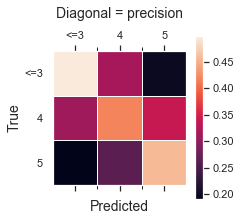

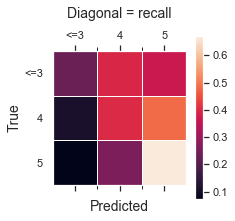

In [91]:
plotConfMat(ycv,yp,figsize=3)

***
## 5b: &emsp; Multi-categorical classification with a binary neural network
***

Here, we investigate whether there is a better solution than classifying each review into a <=3-star, 4-star, or 5-star category. We note that 4-star reviews are obviously better than 3-star reviews but worse than 5-stars. Therefore, we will use a *binary* neural network (i.e. one that classifies an input according to a single output parameter). To do this, we will restrict our training set to only reviews with <=3-stars or 5-stars, and predict a single real-number output for them. Then, on our cross-validation set, we will choose some values, `lower` and `upper`. Then, for a CV set review, $X_i$, we will estimate the output parameter $y_i$, and classify it as 3-stars if $y_i<$ `lower` , as 5-stars if $y_i>$`upper` , and 4-stars otherwise. 
<br>
This has an advantage of requiring fewer weights ($2 \times$ the number of nodes in the last hidden layer fewer), and the arguable benefit of having fewer training examples, so training faster. We will here see if it is at least comparable to the 3-class classification.

In [ ]:
Xtr_bin = Xtr[np.where(ytr.argmax(axis=1)!=1)[0]]
ytr_bin = ytr[np.where(ytr.argmax(axis=1)!=1)[0]].argmax(axis=1)/2

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(Xtr_bin)

seq_tr = tok.texts_to_sequences(Xtr_bin)
seqMat_tr = sequence.pad_sequences(seq_tr,maxlen=max_len)

seq_cv = tok.texts_to_sequences(Xcv)
seqMat_cv = sequence.pad_sequences(seq_cv,maxlen=max_len)

In [366]:
model,modelLoss = createModel(1,embed_num=25) # We are doing a binary classifier now
model.compile(loss=modelLoss,optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 350)               0         
_________________________________________________________________
embed (Embedding)            (None, 350, 25)           25000     
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                23040     
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 48,105
Trainable params: 48,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(seqMat_tr,ytr_bin,batch_size=128,epochs=10,
          validation_split=0.2)

In [97]:
def classify(ycv,yp,lower=.33,upper=.67):
    '''This takes in a y prediction, and marks it as having a review of 4 if lower<yp<upper.'''
    ypClassed = np.ones(len(yp))
    ypClassed[np.where(yp<lower)[0]]=0
    ypClassed[np.where(yp>upper)[0]]=2
    return metrics.accuracy_score(ypClassed,ycv), ypClassed

In [369]:
yp = model.predict(seqMat_cv)

In [370]:
max([classify(ycv,yp,lower,upper)[0] for lower in np.linspace(0,0.5) for upper in np.linspace(0.5,1)])

0.44716666666666666

Note that this method gives relatively high training accuracies (68%+). Cross-validation accuracies are:
<br><br>

equalize=0,   lstm_num=64,dense_num=256,do_num=0.5...
<br>
- embed_num = 200: 46% accuracy
- embed_num = 100: 46% accuracy
- embed_num =  25: 45% accuracy
- embed_num =  10: 44% accuracy

This method seems to give results that are slightly better, and slightly more consistent. Since it is also faster, we will use this in our full evaluation.

***
## 5c: &emsp; Evaluating the model
***

Here we will run our model (multiclass using binary output) on the entire dataset, to get a measure of how well it classifies the reviews.

In [92]:
max_len = 350 
Xtr,ytr,Xcv,ycv = getTRCV(100000,0.7)

Xtr_bin = Xtr[np.where(ytr.argmax(axis=1)!=1)[0]]
ytr_bin = ytr[np.where(ytr.argmax(axis=1)!=1)[0]].argmax(axis=1)/2

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(Xtr_bin)

seq_tr = tok.texts_to_sequences(Xtr_bin)
seqMat_tr = sequence.pad_sequences(seq_tr,maxlen=max_len)
seq_cv = tok.texts_to_sequences(Xcv)
seqMat_cv = sequence.pad_sequences(seq_cv,maxlen=max_len)

In [ ]:
'''
We run this code in a loop over a small number of epochs, since it has a tendency to crash on
my laptop. By doing this we can save the model and the losses every few epochs.
'''

reset = 0

min_delta = 0.001
lossSaver = 'keras_LSTM_loss.txt'
modelFile = 'keras_LSTM_model.h5'

try:
    if reset: raise
    model = load_model(modelFile)
    modelData = np.loadtxt(lossSaver)
    tloss  = list(modelData[0])
    tacc   = list(modelData[1])
    vloss = list(modelData[2])
    vacc  = list(modelData[3])
    print('Loaded')
except:
    model,modelLoss = createModel(1,embed_num=25) 
    model.compile(loss=modelLoss,optimizer=RMSprop(),metrics=['accuracy'])
    tloss  = []
    tacc   = []
    vloss = []
    vacc  = []
    print('Reset')

# Run this a few time, or change the range to a high number.
for run in range(3):
    hist = model.fit(seqMat_tr,ytr_bin,batch_size=128,epochs=5,validation_split=0.02,callbacks=[EarlyStopping(monitor='loss', min_delta=0.01)])
    
    tloss.extend(hist.history['loss'])
    tacc.extend(hist.history['acc'])
    vloss.extend(hist.history['val_loss'])
    vacc.extend(hist.history['val_acc'])
    
    model.save(modelFile)
    np.savetxt(lossSaver,np.array([tloss,tacc,vloss,vacc]))
    
    if tloss[-2]-tloss[-1]<min_delta:
        break

In [100]:
yp   = model.predict(seqMat_cv)

In [101]:
cvset = 10000
acc = 0
bestLower = 0
bestUpper = 0
for lower in np.linspace(0,1):
    for upper in np.linspace(0,1):
        newAcc,ypClassed = classify(ycv[:cvset],yp[:cvset],lower,upper)
        if newAcc>acc:
            acc=newAcc
            bestLower = lower
            bestUpper = upper

# We report accuracy on a different set to that on which we choose bestLower/Upper, to avoid fitting to test data.
acc,ypClassed = classify(ycv[cvset:],yp[cvset:],bestLower,bestUpper)
print('Accuracy =', acc)
print('Best lower =', bestLower)
print('Best upper =', bestUpper)

Accuracy = 0.50685
Best lower = 0.163265306122
Best upper = 0.551020408163


[[ 2570.  2064.   770.]
 [ 1709.  3230.  2607.]
 [  534.  2179.  4337.]]





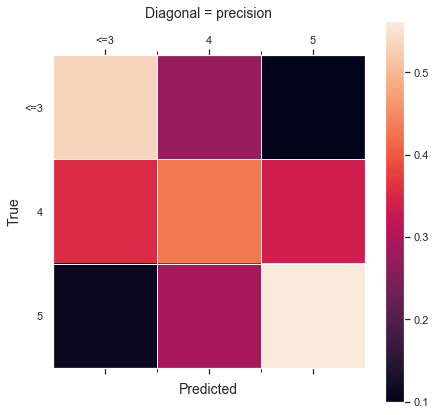

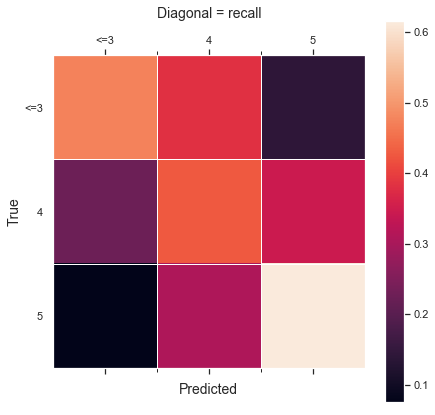

In [109]:
plotConfMat(ycv[cvset:],ypClassed,7)

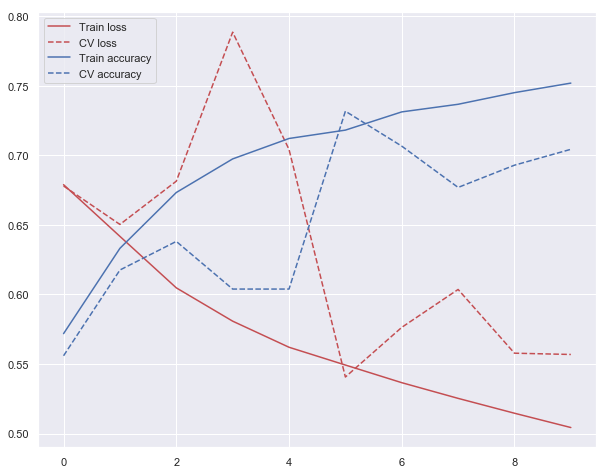

In [107]:
plt.plot(tloss,'r',label='Train loss')
plt.plot(vloss,'r--',label='CV loss')
plt.plot(tacc,'b',label='Train accuracy')
plt.plot(vacc,'b--',label='CV accuracy')
plt.legend()

Note that we use very few examples for finding the CV loss and accuracy, since it is only used for this plot, which explains the high variation. The test set is separate (although called X_cv, y_cv here).

### Thanks for reading

<img src="booksImg.jpg" style="height:500px">